# Reinforcement Learning in bandit tasks and gridworlds

Steven Miletic<br>
<sub>Leiden University<sub><br><br>  
    
This is the code for the practical session in the course "2425-S1 Cognitive Modelling: How to build a brain" [(link to Brightspace)](https://brightspace.universiteitleiden.nl/d2l/home/309838)<br>   
Date: September 30th 2024<br>

Code based on [Franz Wurm's version of last year](https://github.com/fwurm/teaching_CognitiveModelling)

**Useful references**
- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

# 1. Overview

### 1.1 Goal of this practical

In this practical, you are going to implement a reinforcement learning agent for a standard decision-making problem as often used in psychological experiments. Our agent will be learn the value of states and actions in the environment simply by observing their associated rewards and punishments. As discussed in the lecture, this resembles the principles of classical and operant conditioning. It is a efficient way of learning that leads to simple, habitual behavioral patterns.

Step by step, we will discuss the different necessary components to realize such a reinforcement learning agent.

### 1.2 Setting up this notebook 

This notebook contains all necessary information for the first practical session. The exercise is intended to be completed chronologically, i.e. from top to bottom. It includes blocks of text with explanations and code blocks to execute commands and code, including code blocks where you need to add your code.

A few recommendations:
- I recommend to download the file and save it to a separate folder. Ideally, this folder is easily accessible (e.g. on your desktop) or implemented in a preexisting folder structure (e.g. MyBachelor>CogMod>PracticalRL).
- I also recommend to work with copies. That means, don't work on the original file, but rather work on a copy. This makes sure that you do not delete important information and always have a basis to go back to. Additionally, you could implement version control, meaning you save your work to a new file from time to time (e.g., filename_v1, filename_v2). This makes sure you dont lose too much progress in case your computer shuts down or you forgot to press the save button.
- For working on the excersises of the practical I suggest you use [Google Colab](https://colab.research.google.com/) or [Jupyter-notebook](https://jupyter.org/). While Google Colab is straight-foward to use, Jupyter-notebook might require you to install additional software (e.g., [Anaconda](https://anaconda.org/)).


In [3]:
# first, let's import some packages that we need

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. A simple k-armed bandit task

In the [bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit), the agent is faced with a choice between $k$ multiple options. Named after slot machines in a casino, our one and two-armed versions in the lecture were used to demonstrate the two core principles that allow the agent to achieve his goal of reward maximzation.

First, we'll simulate 'drawing' or 'sampling' from a bandit in a function -- i.e., we simulate pulling the lever of a slot machine. To simulate a slot machine, we need to specify how often the slot machine gives out a reward. That means that we need to specify the _reward distribution_, which is a probability distribution.

The functions below uses a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). That is, on every draw, the bandit/slot machine either gives a reward, or not. The probability of reward is user-specified, and given by the argument <code>prob</code>.

In [157]:
def draw_from_one_bandit(n_trials, prob):
    
    reward_samples = np.random.binomial(1,prob,n_trials)  # this simulates the rewards
    
    return reward_samples

def draw_from_k_bandits(n_trials, probs):
    
    n_bandits = len(probs)  # how many arms?
    
    # preallocate output
    reward_samples = np.empty((n_bandits, n_trials))
    reward_probs = np.empty((n_bandits, n_trials))
    
    for i, prob in enumerate(probs):
        reward_samples[i,:] = draw_from_one_bandit(n_trials, prob)
        reward_probs[i,:] = prob
        
    return reward_samples, reward_probs

<div class="alert alert-warning" role="alert">
<h2> 2.1 Let's try it out! </h2><br>

Generate two bandits with each 100 trials. The bandits should have reward probabilities of 80% and 20%, respectively.

Verify that the simulated reward probabilities are indeed 80% and 20%. (hint: <code>np.mean()</code> can easily calcuate the mean)

Try to write efficient code (few lines)!
    
</div>


In [158]:
## TODO: create bandits and print average reward

n_trials = 100
probs = [0.8, 0.2]

reward_samples, reward_probs = draw_from_k_bandits(n_trials, probs)

#print(reward_samples)
print(reward_probs)
print(f'mean: {np.mean(reward_samples,axis=1)}')

[[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]]
mean: [0.8  0.15]


### Learning and deciding
As discussed in the lecture, the two principles of reinforcement learning are
- the learning rule: _updating_ of expectations based on observations 
- the decision rule: taking _actions_ based on expectations

Below, we'll first try out different learning rules.

## 3. The learning rule

The learning rule should help our agent to build up expectations about its environment.

In this section, we are going to demonstrate why a _weighted-average_ method outperforms the _average_ method in changing environments.

#### 3.1 Calculating the average

As a first step, let us have a look at the performance of the averaging method for incremental learning in a stable environment.

We specify the learning rule for incremental averaging in acordance with the formula introduced in the lecture.

$V_{t+1} = V_{t} + \frac{1} {t}(R_{t} - V_{t})$,

>where $V$ is the estimated average value,<br>
>and $t$ is the current time step.<br>

The code below implements the incremental average method in a 'static' environment (i.e., the reward probabilities don't change across time)

In [159]:
n_trials = 1000
prob = [0.7]

reward_samples, reward_probs = draw_from_k_bandits(n_trials,prob)

mean_avg = np.empty((1,n_trials+1))   # Pre-allocate an array in which we'll store the running averages
for iT in np.arange(n_trials):
    if iT == 0:
        mean_avg[0,0] = 0.5     ## Think about this for a moment: what are we doing here?
    mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[0,iT]-mean_avg[0,iT])
    
    
print(mean_avg)

[[0.5        0.         0.         ... 0.69639279 0.6966967  0.696     ]]


<div class="alert alert-warning" role="alert">
<h2> 3.2 Challenge </h2><br>

Show that the incremental average mean indeed converges to the true reward probability.
    
>Use the <code>print</code> function and the matplotlib methods, loaded as <code>plt</code> to visualize the values obtained from the average method across trials
</div>

mean: [0.5        0.         0.         0.33333333 0.5        0.4
 0.5        0.57142857 0.625      0.66666667 0.7        0.72727273
 0.75       0.76923077 0.78571429 0.8        0.75       0.76470588
 0.72222222 0.68421053]
mean: [0.686      0.68463074 0.68525896 0.68588469 0.68452381 0.68514851
 0.68577075 0.68639053 0.68700787 0.68762279 0.68627451 0.68688845
 0.68554688 0.68421053 0.68287938 0.68349515 0.68410853 0.68471954
 0.68532819 0.68400771]
mean: [0.69693878 0.69724771 0.69653768 0.69684639 0.69715447 0.6964467
 0.69675456 0.6970618  0.69635628 0.69565217 0.69494949 0.69525732
 0.69455645 0.69486405 0.69517103 0.69547739 0.69578313 0.69608826
 0.69639279 0.6966967  0.696     ]


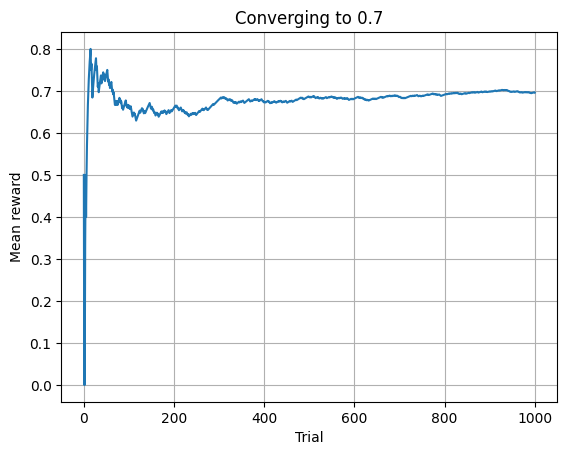

In [164]:
# Your code here

print(f'mean: {mean_avg[0,0:20]}')
print(f'mean: {mean_avg[0,500:520]}')
print(f'mean: {mean_avg[0,980:]}')

plt.plot(mean_avg[0,:])
plt.xlabel('Trial')
plt.ylabel('Mean reward')
plt.title('Converging to 0.7')
plt.grid(True)




#### 3.3 ...in changing environments

So far, that looks great -- the average method of incremental learning does a good job in estimating the average on a step-by-step basis. However, what happens if the environment is not stable? By 'unstable' or 'changing' environments, we mean environments in which the reward probabilities change across trials.

Below, the code simulates a changing environment by drawing 1000 samples from a bandit with 70% reward probability, followed by 1000 samples with 30% reward probability, followed by another 1000 trials with 70% reward probability, etc. The _average_ method is used to estimate the value of the bandit.

In [165]:
n_trials = 1000
probs = [0.7, 0.3, 0.7, 0.3, 0.7, 0.3]

reward_samples, reward_probs = draw_from_k_bandits(n_trials,probs)

# Simulate a bandit with changing reward probabilities by
# flattening a m-by-n matrix into a 1-by-m*n vector
reward_samples = reward_samples.flatten()
reward_probs = reward_probs.flatten()
# this problem could also be solved by multiple loops

mean_avg = np.empty((1,len(reward_probs)+1))
for iT in np.arange(len(reward_probs)):    
    if iT==0: #initialize at time point 0
        mean_avg[0,0] = 0.5
    #update estimated values    
    mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[iT]-mean_avg[0,iT])

<div class="alert alert-warning" role="alert">
<h2> 3.4 Challenge </h2><br>

Like you did in challenge 3.2, plot the estimated value obtained with the mean method over trials, and compare these with the true reward probabilities.

Think about the results as displayed in the figure. How well does the average method capture the true reward probabilities? Why does it fail to do a very good job?

</div>

mean: [0.5        0.         0.         0.33333333 0.25       0.4
 0.5        0.57142857 0.5        0.44444444 0.4        0.45454545
 0.5        0.53846154 0.5        0.53333333 0.5625     0.58823529
 0.61111111 0.57894737]
mean: [0.724      0.7245509  0.7250996  0.72564612 0.72619048 0.72673267
 0.72529644 0.72583826 0.72637795 0.72495088 0.72352941 0.72407045
 0.72265625 0.72319688 0.72373541 0.72427184 0.72286822 0.72340426
 0.72200772 0.72061657]
mean: [0.71734694 0.7166157  0.71690428 ... 0.49733244 0.49741624 0.4975    ]


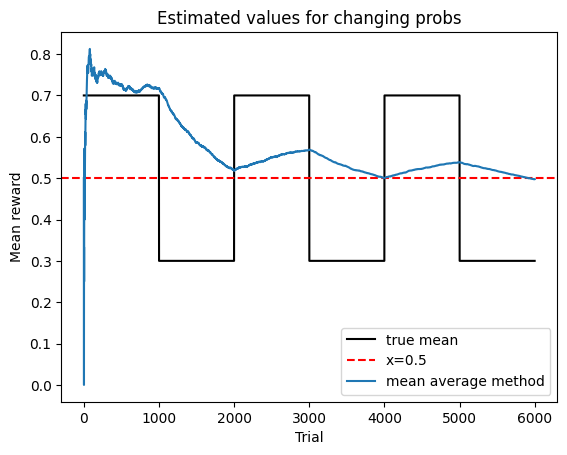

In [179]:
# Your code here
print(f'mean: {mean_avg[0,0:20]}')
print(f'mean: {mean_avg[0,500:520]}')
print(f'mean: {mean_avg[0,980:]}')
plt.plot(np.arange(len(reward_probs)),reward_probs,'-k',label = 'true mean')
plt.axhline(y=0.5, color= 'red', linestyle='--', label= 'x=0.5')

plt.plot(mean_avg[0,:], label= 'mean average method')
plt.xlabel('Trial')
plt.ylabel('Mean reward')
plt.title('Estimated values for changing probs')
plt.legend()

#all timesteps are considered equallluy, hence it does not work, 
#averages at 0.5, which is the average of the overall reward average, but it does not account for the charactersitics of the the changing environment


As discussed in the lecture, the _weighted average_ method is often used as an improvement on the average method. The corresponding update rule is as follows:

$V_{t+1} = V_{t} + \alpha(R_{t} - V_{t})$,

where $\alpha$ is the learning rate.

<div class="alert alert-warning" role="alert">
<h2> 3.5 Challenge </h2><br>

The code block below is a copy from the code block above, that simulates an unstable environment and uses the average method to learn the value.

In the code block below, you need to add the estimates of values obatined using the _weighted average_ method. That is, implement the learning rule with the equation in the cell above. Assume a learning rate of 0.05.

</div>

In [176]:
# Add your code in this block

n_trials = 1000
probs = [0.7, 0.3, 0.7, 0.3, 0.7, 0.3]
learning_rate = 0.009 #0.05 to changing nice for 0.05 to 0.09, if 0.00001 no adption, if 0.5, to wild

reward_samples, reward_probs = draw_from_k_bandits(n_trials,probs)

# Simulate a bandit with changing reward probabilities by
# flattening a m-by-n matrix into a 1-by-m*n vector
reward_samples = reward_samples.flatten()
reward_probs = reward_probs.flatten()
# this problem could also be solved by multiple loops

mean_avg1 = np.empty((1,len(reward_probs)+1))
for iT in np.arange(len(reward_probs)):    
    if iT==0: #initialize at time point 0
        mean_avg1[0,0] = 0.5
    #update estimated values    
    mean_avg1[0,iT+1] = mean_avg1[0,iT] + learning_rate*(reward_samples[iT]-mean_avg1[0,iT])

<div class="alert alert-warning" role="alert">
<h2> 3.6 Challenge </h2><br>

Plot the results again. In your plot, include both the value estimates from the average and the weighted average method. Think about the results for a moment. Which method works better? And why?

And what happens if you increase/decrease the learning rate?
</div>

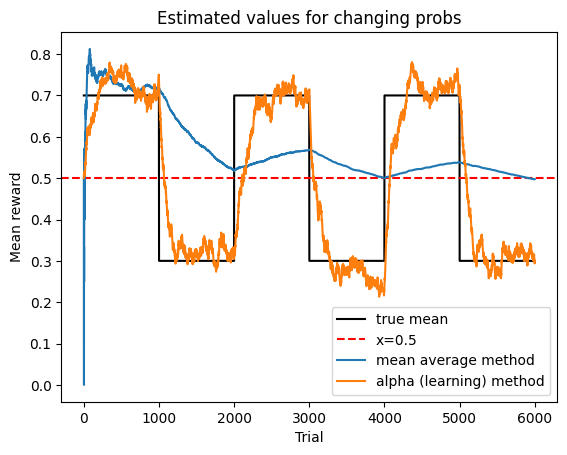

In [181]:
# Your plotting code here
plt.plot(np.arange(len(reward_probs)),reward_probs,'-k',label = 'true mean')
plt.axhline(y=0.5, color= 'red', linestyle='--', label= 'x=0.5')

plt.plot(mean_avg[0,:], label= 'mean average method')
plt.plot(mean_avg1[0,:], label= 'alpha (learning) method')
plt.xlabel('Trial')
plt.ylabel('Mean reward')
plt.title('Estimated values for changing probs')
plt.legend()


# 4. Decision rules: Policy

So far, we have only dealt with prediction problems. However, the most powerful application of reinforcement learning lies in solving control problems. 

The decision rule (or policy) defines the agent's way of behaving at a given time or state. This is an extension of the previous prediction problem, as we now also consider actions given each state. Put differently, the policy is a mapping between states and actions and it corresponds to what psychologists sometimes call a stimulus-response association.


### 4.1 Improving decision making... by exploration

In order to replicate the results for the improvement of decision-making as shown in the lecture, we first need to set up a new bandit function.

This new bandit function again takes two input parameters and gives two output variables. In contrast to the previous bandit, the current bandit will draw its reward from a normal (Gaussian) distribution. That means that, contrary to previous bandits that either gave a reward or gave no reward, the new bandits _always_ give a reward, but the amount of reward is continuous follows a Gaussian distribution.


<div class="alert alert-warning" role="alert">
<h2> 4.2 Challenge </h2><br>

Add a function to the routine below that samples rewards from a normal distribution with a mean of <code>mean_rewards</code> and a standard deviation of <code>1</code>. <br>
<br>
    
>HINT: Replace the <code>???</code> in the box below with the appropriate function.

</div>

(array([  2.,   1.,   1.,  13.,  21.,  31.,  56., 101., 119., 129., 143.,
        121., 103.,  72.,  36.,  28.,  11.,   9.,   1.,   2.]),
 array([-2.58032709, -2.22347069, -1.8666143 , -1.50975791, -1.15290151,
        -0.79604512, -0.43918872, -0.08233233,  0.27452406,  0.63138046,
         0.98823685,  1.34509324,  1.70194964,  2.05880603,  2.41566242,
         2.77251882,  3.12937521,  3.48623161,  3.843088  ,  4.19994439,
         4.55680079]),
 <BarContainer object of 20 artists>)

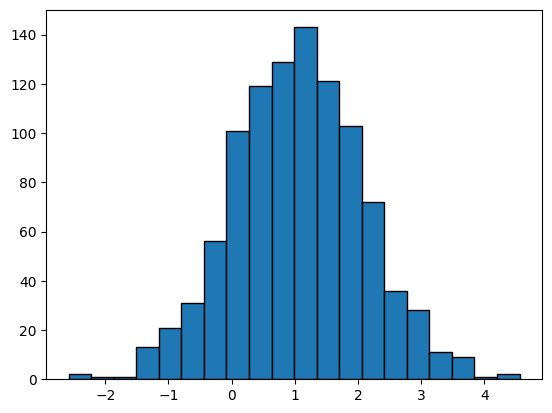

In [182]:
def draw_from_one_gaussian_bandit(n_trials, mean_reward):
    
    reward_samples = np.random.normal(mean_reward, 1, n_trials)  # gaussian reward distribution
    
    return reward_samples

def draw_from_k_gaussian_bandits(n_trials, mean_rewards):
    
    n_bandits = len(mean_rewards)  # how many arms?
    
    # preallocate output
    reward_samples = np.empty((n_bandits, n_trials))
    reward_means= np.empty((n_bandits, n_trials))
    
    for i, mean_reward in enumerate(mean_rewards):
        reward_samples[i,:] = draw_from_one_gaussian_bandit(n_trials, mean_reward)
        reward_means[i,:] = mean_reward
        
    return reward_samples, reward_means

#verifiying that the districution of rewards is correct
l = draw_from_one_gaussian_bandit(1000, 1)

plt.hist(l, bins=20, edgecolor='black')

During the lecture, we introduced a few different decision rules and of course the list in not exhaustive. Below you find the most commonly used methods:
- random method
- greedy method
- e-greedy method (nb: e is for epsilon)
- softmax method

Let's first implement the different methods for action selection.

In [184]:
def action_random(values):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    action = np.random.choice(actions)    # this literally just takes a (uniform distributed) random draw
    
    return action

def action_greedy(values):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    max_value = np.max(values[:, 0])
    ties = np.isclose(values[:, 0], max_value)
    
    if np.any(ties):
        action = np.random.choice(actions[ties])  # Choose randomly among ties
    else:
        action = np.random.choice(actions)  # Fallback in case there are no valid ties
    
    return action


def action_epsilon(values,epsilon):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    if (np.random.uniform() < epsilon):
        action = action_random(values)
    else:
        action = action_greedy(values)
    
    return action

Let's make a few assumptions for our simulation first.

In [185]:
n_agents = 100
n_trials = 1000
n_bandits = 10

### 4.3.1 Greedy agents

In the following code block I have set up a number of greedy agents.

In accordance with the lecture, both the average for the rewards (<code>rewards_greedy</code>) and the percentage of optimal decisions (<code>optimum_greedy</code>) will be saved for plotting.

Please note, that we implement the _average methode_ as the learning rule. As this is a stable environment, the properties of the average method guarantee that our estimates converge to the true value (at least with an appropriate action selection method...).

/var/folders/fy/706lxrys0wz382tbd9m0rfbc0000gn/T/ipykernel_58333/717818597.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  values[action,0] = values[action,0] + (1/iT)*PE
/var/folders/fy/706lxrys0wz382tbd9m0rfbc0000gn/T/ipykernel_58333/717818597.py:23: RuntimeWarning: invalid value encountered in scalar add
  values[action,0] = values[action,0] + (1/iT)*PE


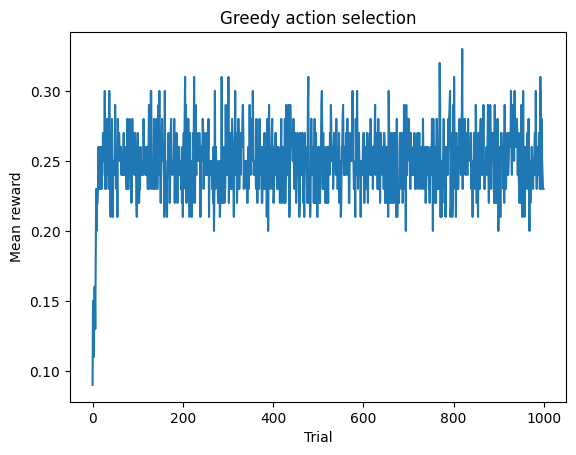

In [186]:
## greedy action selection

rewards_greedy = np.empty((n_agents,n_trials))
optimum_greedy = np.empty((n_agents,n_trials))

for iA in np.arange(n_agents):

    reward_means = np.random.normal(0,1,(n_bandits,1))
    optimal_action = np.argmax(reward_means)
    reward_samples, reward_probs = draw_from_k_gaussian_bandits(n_trials, reward_means)

    #initialize the estimated values for each bandit
    values = np.zeros((len(reward_means),1))
    action_count = np.zeros((len(reward_means),1))
    
    for iT in np.arange(n_trials):    
        #chose action
        action = action_greedy(values)
        action_count[action,0] =  action_count[action,0]+1
        #calculate prediction error
        PE = reward_samples[action,iT]-values[action,0]
        #update value
        values[action,0] = values[action,0] + (1/iT)*PE

        #store reward & optimal decision
        rewards_greedy[iA,iT] = reward_samples[action,iT]
        if action == optimal_action:
            optimum_greedy[iA,iT] = 1
        else:
            optimum_greedy[iA,iT] = 0
            
            
plt.plot(np.mean(optimum_greedy,axis=0))
plt.xlabel('Trial')
plt.ylabel('Mean reward')
plt.title('Greedy action selection')
plt.show()


### 4.3.2 $\epsilon$-greedy action selection

Basically, the $\epsilon$-greedy agent is identical to the greedy agent with the the minor detail that on 100*$\epsilon$% of the trials a random action will be chosen.

You find the code for $\epsilon$-greedy actions selection already above.

In [187]:
#important to implement correct updating rule, use alpha instead of 1/Ti

epsilon = 0.1

rewards_egreedy = np.empty((n_agents,n_trials))
optimum_egreedy = np.empty((n_agents,n_trials))
for iA in np.arange(n_agents): 

    reward_means = np.random.normal(0,1,(n_bandits,1))
    optimal_action = np.argmax(reward_means)
    reward_samples, reward_probs = draw_from_k_gaussian_bandits(n_trials,reward_means)

    #initialize the estimated values for each bandit
    values = np.zeros((len(reward_means),1))
    action_count = np.zeros((len(reward_means),1))
    
    for iT in np.arange(n_trials):    
        #chose action
        action = action_epsilon(values,epsilon)
        action_count[action,0] =  action_count[action,0]+1
        #calculate prediction error
        PE = reward_samples[action,iT]-values[action,0]
        #update value
        #values[action,0] = values[action,0] + (1/iT)*PE
        # # update value estimate with correct step size
        alpha = 1 / action_count[action, 0]  # step size is 1/N(a)
        values[action, 0] += alpha * PE
        #store reward
        rewards_egreedy[iA,iT] = reward_samples[action,iT]
        if action == optimal_action:
            optimum_egreedy[iA,iT] = 1
        else:
            optimum_egreedy[iA,iT] = 0     


Now let's plot the results and compare greedy vs epsilon-greedy action selection

Text(0, 0.5, '% optimal choice')

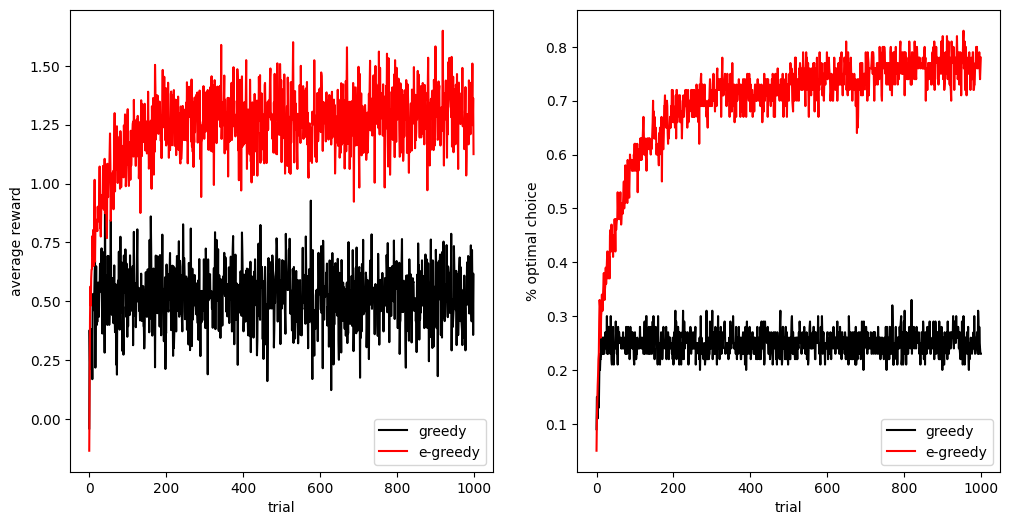

In [189]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.plot(np.arange(n_trials),np.mean(rewards_greedy,0),'-k',label='greedy')
ax.plot(np.arange(n_trials),np.mean(rewards_egreedy,0),'-r',label='e-greedy')
plt.legend(loc="lower right") 
ax.set_xlabel('trial')
ax.set_ylabel('average reward')
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(n_trials),np.mean(optimum_greedy,0),'-k',label='greedy')
ax2.plot(np.arange(n_trials),np.mean(optimum_egreedy,0),'-r',label='e-greedy')
plt.legend(loc="lower right")   
ax2.set_xlabel('trial')
ax2.set_ylabel('% optimal choice')

<div class="alert alert-warning" role="alert">
<h2> 4.3.3 Challenge </h2><br>

Huh, that's strange. These results do not seem to replicate the results from Sutton & Barto. In silico, the $\epsilon$-greedy method should outperform the greedy method for this environment. 
However it does not seem to do so in our simulation.

Can you figure out what's wrong with the code above? Hint: Have a look at the used updating function, and compare it with the correct updating function in the slides.



</div>

Challenge done!!!

### 4.3.4 Softmax action selection

Let's have a closer look at the softmax rule, as this is maybe the most widely used decision rule in the neuroscientific literature.

$\LARGE p(a)= \frac{e ^{(\beta * Q(a))}} {\sum \limits _{a'} e ^{(\beta * Q(a'))}}$ 

In [124]:
def action_softm(values,beta):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    prob = (np.exp(beta*values))/(np.sum(np.exp(beta*values))) # softmax action selection
    action = np.random.choice(actions,size = 1, p = prob) 

    return action, prob

<div class="alert alert-warning" role="alert">
<h2> 4.3.5 Challenge </h2><br>

The central part of the softmax algorithm is missing. Fill in the missing code.
    
>HINT: Use prespecified numpy methods.
</div>

If we want to put this softmax function to use, we can make a few hypothetical assumptions for our bandit task.

For example, let's assume our agent has played the slot machine twice, each arm one time. The left arm lead to a reward (1), whereas the right arm did not result in a reward (0). We can translate this experience into simplified expectations (values) for the next game.

In [127]:
dummy_values = np.array([1,0])
beta = 1

action, prob = action_softm(dummy_values,beta)

# print('Chosen action: %d' % (action))
# print('Action probablities: %s' % (np.array2string(prob)))
print(prob)

[0.73105858 0.26894142]


We can see, that the dummy expectations translate into action probabilites in a straightforward way. The highest value has the highest action probability.

<div class="alert alert-warning" role="alert">
<h2> 4.3.6 Idea </h2><br>
Play around with the beta value and observe the changes!
    
</div>

As already discussed in the lecture, the beta (or 'inverse temperature') affects the so-called [gain](https://en.wikipedia.org/wiki/Gain_(electronics)). The higher the gain, the more pronounced the differences in action values get translated into action probabilities.

We can plot this in a systematic way.

<div class="alert alert-warning" role="alert">
<h2> 4.3.7 Challenge </h2><br>
Setup a plot similar to the slide in the lecture.<br>
- x-axis: differences in values<br>
- y-axis: action probablity for option 1<br>
    
</div>


In [150]:
# softmax for difference reduces to +1 bcs of exp(0) = 1
def softmaxdiff(x,beta):
    prob = np.exp(beta * x) / (np.exp(beta * x) + 1)
    return action, prob

betas = [0,1,2,5,10]
x = np.arange(-2,2,0.1)
print(x)

# all_probs = np.empty((len(betas),len(x)))
all_probs = np.empty((len(betas), len(x)))

## TODO: calculate action probabilities for each [beta,x] pair
for i, beta in enumerate(betas):
    _ , all_probs[i, :] = softmaxdiff(x,beta)
    #_, all_probs[i, :] = action_softm(x,beta)

[-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00]


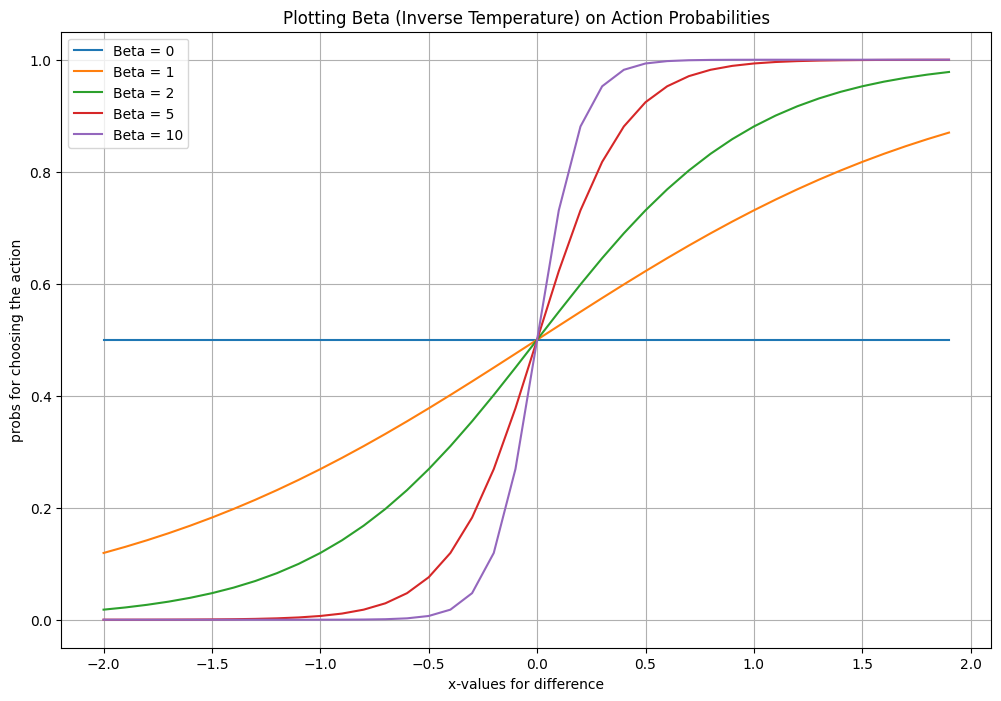

In [152]:
## Your code here: Plot the results
# create graph of 0,0
plt.figure(figsize=(12, 8))
for i, beta in enumerate(betas):
    plt.plot(x, all_probs[i, :], label=f'Beta = {beta}')

plt.xlabel('x-values for difference')
plt.ylabel('probs for choosing the action')
plt.title('Plotting Beta (Inverse Temperature) on Action Probabilities')
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-success" role="alert">
<h2> Assignments and more </h2><br>

Congratulations! You have reached the end of the notebook. I hope you have learned something about reinforcement learning.

Now it is time for your assignment. You find the assignments, additional material in the "solution" notebook.

Feel free to discuss your own ideas for assignments with the workgroup teacher!
    
</div>

Assignment 1: 

In [230]:

def generate_uniform_bandit(n_trials, prob):
    return np.random.binomial(1, prob, size=n_trials)

def generate_walking_binomial_bandit(n_trials, start_prob=0.5, std_dev=0.05):
    probs = np.zeros(n_trials)
    probs[0] = start_prob
    
    for t in range(1, n_trials):
        probs[t] = np.clip(probs[t-1] + np.random.normal(0, std_dev, 1), 0, 1)
    rewards = np.random.binomial(1, probs)
    return rewards, probs 

def generate_gaussian_bandit(n_trials, mean_reward, std_dev=0.05):
    
    return np.clip(np.random.normal(mean_reward, std_dev, size=n_trials), 0, 1)  


def generate_walking_gaussian_bandit(n_trials, start_prob=0.5, std_dev_n=0.05, std_dev=0.05):
    
    probs = np.zeros(n_trials)
    probs[0] = start_prob
    
    for t in range(1, n_trials):
        probs[t] = np.clip(probs[t-1] + np.random.normal(0, std_dev_n ,1), 0, 1)
    
    rewards = np.random.normal(probs, std_dev)
    rewards = np.clip(rewards, 0, 1)  
    return rewards, probs



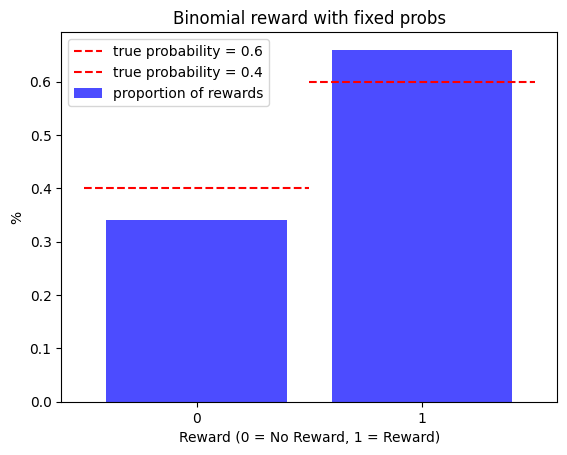

In [238]:
# Run and visualize agents

#1
n_trials = 100
fixed_binomial_bandit = generate_uniform_bandit(n_trials, prob=0.6)

# Plotting
unique, counts = np.unique(fixed_binomial_bandit, return_counts=True)
plt.bar(unique, counts / n_trials, color='blue', alpha=0.7, label='proportion of rewards')
plt.hlines(0.6, 0.5, 1.5, color='red', linestyles='--', label='true probability = 0.6')
plt.hlines(0.4, -0.5, 0.5, color='red', linestyles='--', label='true probability = 0.4')
plt.title("Binomial reward with fixed probs")
plt.xlabel("Reward (0 = No Reward, 1 = Reward)")
plt.ylabel("%")
plt.xticks([0, 1])
plt.legend()
plt.show()



/var/folders/fy/706lxrys0wz382tbd9m0rfbc0000gn/T/ipykernel_58333/3715784342.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probs[t] = np.clip(probs[t-1] + np.random.normal(0, std_dev, 1), 0, 1)


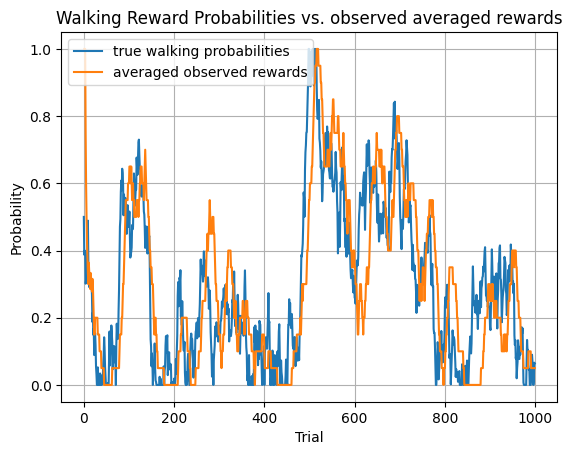

In [248]:
#2
# Example for visualization
n_trials = 1000
walking_binomial_bandit, walking_probs = generate_walking_binomial_bandit(n_trials)
means = np.zeros(len(walking_binomial_bandit))
#for interval of 20 
for j, i in enumerate(walking_binomial_bandit): 
        if j>20: 
                means[j] = np.mean(walking_binomial_bandit[j-20:j])
        else: 
                means[j] = np.mean(walking_binomial_bandit[:j])
        # or general average

        #means[j] = np.mean(walking_binomial_bandit[:j])

# Visualization
plt.plot(walking_probs, label='true walking probabilities')
plt.plot(means, label='averaged observed rewards')
plt.title("Walking Reward Probabilities vs. observed averaged rewards")
plt.xlabel("Trial")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()


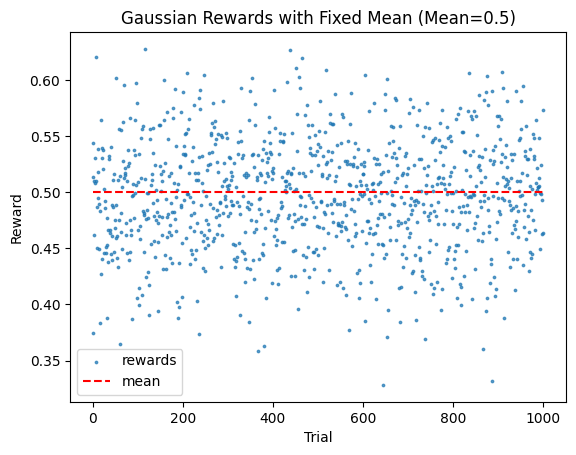

In [273]:
#3
fixed_gaussian_bandit = generate_gaussian_bandit(n_trials, mean_reward=0.5)

# Visualization
plt.scatter(np.arange(n_trials),fixed_gaussian_bandit, marker = 'o', s=3, alpha= 0.7, label='rewards')
plt.hlines(0.5, 0, n_trials, color='red', linestyles='--', label='mean')
plt.title("Gaussian Rewards with Fixed Mean (Mean=0.5)")
plt.xlabel("Trial")
plt.ylabel("Reward")
plt.legend()
plt.show()

/Users/jessekroll/Desktop/VScode/reifl-a4/.conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jessekroll/Desktop/VScode/reifl-a4/.conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


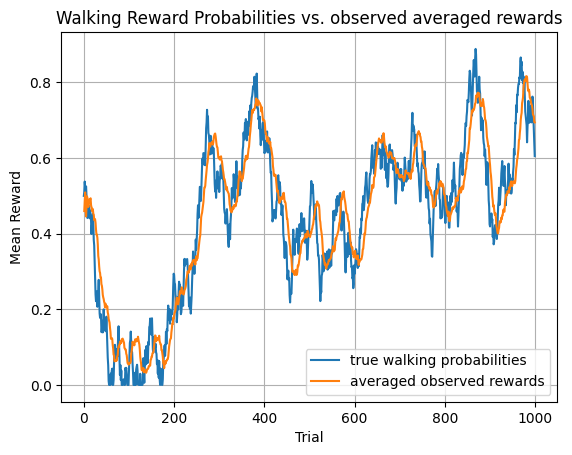

In [288]:
#4
walking_gaussian_bandit, walking_means = generate_walking_gaussian_bandit(n_trials)

means = np.zeros(len(walking_gaussian_bandit))
#for interval of 20 
for j, i in enumerate(walking_gaussian_bandit): 
        if j>20: 
                means[j] = np.mean(walking_gaussian_bandit[j-20:j])
        else: 
                means[j] = np.mean(walking_gaussian_bandit[:j])
        #or general average

        #means[j] = np.mean(walking_gaussian_bandit[:j])
# Visualization
plt.plot(walking_means, label='true walking probabilities')
plt.plot(means, label='averaged observed rewards')
plt.title("Walking Reward Probabilities vs. observed averaged rewards")
plt.xlabel("Trial")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.legend()
plt.show()


Comparing performance on fixed binomial bandit


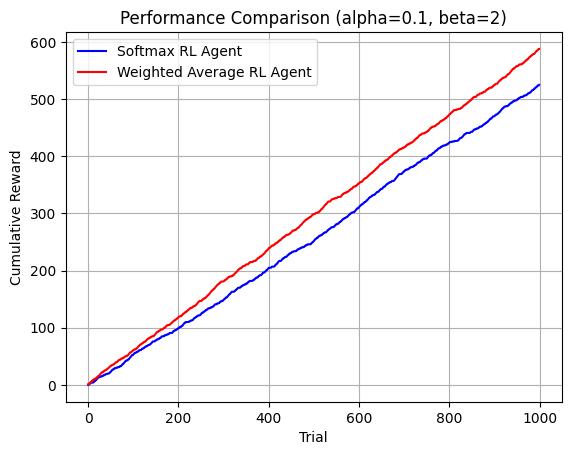

Comparing performance on fixed Gaussian bandit


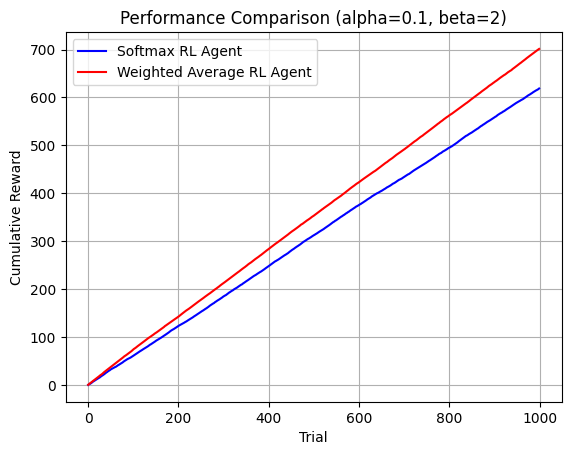

In [326]:
#Comparing performances of Softmax and Weighted Average RL agents

# update rule
def update_values(values, action, reward, alpha):
    values[action] += alpha * (reward - values[action])

# Softmax 
def run_softmax_rl_agent(n_trials, bandit_func, beta=10, alpha=0.1):
    values = np.zeros(2)  # 2-armed bandit
    rewards = []
    
    for t in range(n_trials):
        action, _ = action_softm(values, beta)
        reward = bandit_func(action, t)
        update_values(values, action, reward, alpha)
        rewards.append(reward)
    
    return rewards

# Weighted Average 
def run_weighted_average_rl_agent(n_trials, bandit_func, alpha=0.1):
    values = np.zeros(2)  # Initialize action values for two-armed bandit
    rewards = []
    
    for t in range(n_trials):
        action = np.argmax(values)
        reward = bandit_func(action, t)
        update_values(values, action, reward, alpha)
        rewards.append(reward)
    
    return rewards


# Bandit functions for two-armed bandit

def two_armed_binomial_fixed(action, t):
    """Two-armed binomial bandit with fixed probabilities."""
    if action == 0:
        r = generate_uniform_bandit(n_trials,0.6 )
        return r[0]  # Arm 1 with p = 0.6
    else:
        r = generate_uniform_bandit(n_trials,0.4 )
        return r[0]  # Arm 1 with p = 0.4
    
#continue here!!!!!!!!
    
    
    
    
    
    
    
    
    
    
def two_armed_gaussian_fixed(action, t):
    """Two-armed Gaussian bandit with fixed mean rewards."""
    if action == 0:
        return np.clip(np.random.normal(0.7, 0.1), 0, 1)  # Arm 1 with mean = 0.7
    else:
        return np.clip(np.random.normal(0.5, 0.1), 0, 1)  # Arm 2 with mean = 0.5

# Visualization of performance comparison between agents

def visualize_performance(n_trials, bandit_func, alpha=0.1, beta=2):
    """Visualizes the performance of softmax and weighted average RL agents."""
    # Run Softmax RL agent
    rewards_softmax = run_softmax_rl_agent(n_trials, bandit_func, beta, alpha)
    
    # Run Weighted Average RL agent
    rewards_weighted_avg = run_weighted_average_rl_agent(n_trials, bandit_func, alpha)
    
    # Compute cumulative rewards for both agents
    cumulative_rewards_softmax = np.cumsum(rewards_softmax)
    cumulative_rewards_weighted_avg = np.cumsum(rewards_weighted_avg)
    
    # Plotting cumulative rewards over trials
    plt.plot(cumulative_rewards_softmax, label="Softmax RL Agent", color='blue')
    plt.plot(cumulative_rewards_weighted_avg, label="Weighted Average RL Agent", color='red')
    
    plt.title(f"Performance Comparison (alpha={alpha}, beta={beta})")
    plt.xlabel("Trial")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters for the experiment
n_trials = 1000

# Compare performance on a fixed binomial bandit
print("Comparing performance on fixed binomial bandit")
visualize_performance(n_trials, two_armed_binomial_fixed)

# Compare performance on a fixed Gaussian bandit
print("Comparing performance on fixed Gaussian bandit")
visualize_performance(n_trials, two_armed_gaussian_fixed)
